# IEEE SPS Seasonal School on Networked Federated Learning 
# https://ieeespcasfinland.github.io/
# Exericse 2 

A. Jung, 2022 
(alex.jung@aalto.fi)

# Learning Goals 

After completing this exercise, you should 

* be able to model networked data using an undirected weighted empirical graph
* be familiar with basic functionality of the Python package `networkx`
* be able to store an empirical graph as a [`networkx.Graph`](https://networkx.org/documentation/stable/reference/classes/graph.html#networkx.Graph) object
* be able to store and process local datasets and model parameters as node attributes of a `networkx.Graph` object 
* be able to compute averages of node attributes of a `networkx.Graph` object in a distributed fashion  
* be able to combine gradient descent with a network averaging algorithm to learn (in a distributed fashion) a single linear hypothesis map from a network of local datasets

# Networked Data and Models - The Empirical Graph

Many important application domains, ranging from the internet of things to high-precision management of pandemics, generate collections of local datasets that are related by some network structure. We can conveniently represent such networked data by an undirected weighted graph, which we refer to as an empirical graph. The nodes of the  empirical graph, which are indexed using $i=0,1,\ldots$, carry local datasets. Each local dataset consists of several individual data points. 

Different local datasets are related by some notion of similarity that is represented by a set $\mathcal{E}$ of undirected edges. Consider nodes representing spatially distributed sensing devices. The measurments of a sensing device constitute local datasets and we can expect that the statistical properties of local datasets generated by near-by sensing devices to have similar statistics. For two similar data sets, connected by an edge $\{i,j\}$, we quantify their similarity by a positive edge weight $A_{ij}>0$. The neighborhood $\mathcal{N}(i)$ of a node $i$ is the set of all other nodes $j$ that are connected with node $i$ by and edge $\{i,j\}$. The degree $d_{i}:=|\mathcal{N}(i)|$ of a node $i$ is the number of its neighbours.  

To summarize, an empirical graph is an object that represents a collection of local datasets along with their similarities. We will use an empirical graph not only to represent networked data but also the corresponding networked models. In particular, each node in an empirical graph will be assigned a separate set of model parameters ("weight vector") that can be tuned independently. 

The Python package `networkx` provides convenient means for storing and manipulating networked data and models. We will demonstrate how to generate and process an empirical graph using the class `networkx.Graph` and its methods. 

# Demo 2.1 - A Toy Example for Networked Data 

The code snippet below generates a `networkx.graph` object `G` that represents a toy dataset consisting of 6 local datasets. Each local dataset is assigned to a node of `G`. The nodes of `G` are partitioned into two blocks. 

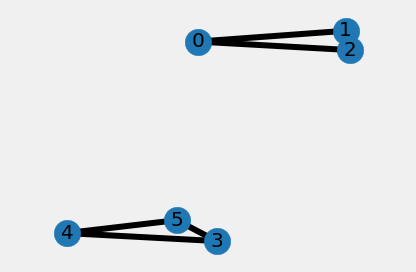

In [25]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np 

G = nx.Graph()  # creates an object that represents an empty graph (no nodes, no edges)

G.add_nodes_from(range(6))  # add six nodes i=0,..,5 to the graph G. 

# for each node add attribute "block" that indicates to which block the node belongs 

# assign nodes i=0,1,2 to block 0 

G.nodes[0]["block"] = 0 
G.nodes[1]["block"] = 0 
G.nodes[2]["block"] = 0 

# assign nodes i=3,4,5 to block 1

G.nodes[3]["block"] = 1 
G.nodes[4]["block"] = 1 
G.nodes[5]["block"] = 1 


# add egdes (i,j) along with a weight A_ij 

#intra-cluster edges for block 0 
G.add_edge(0, 1, weight=0.6)
G.add_edge(0, 2, weight=0.7)
G.add_edge(1, 2, weight=0.6)

#inter-cluster edge between block 0 and 1 
#G.add_edge(2, 3, weight=0.0)

# intra-cluster edges for block 1 
G.add_edge(3, 4, weight=0.7)
G.add_edge(4, 5, weight=0.9)
G.add_edge(3, 5, weight=0.6)


# determine the edges whose weight is smaller than 1/2
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
# determine the edges whose weight is larger or equal than 1/2 
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

# determine convenient coordinates for illustrating nodes in a plane
pos = nx.spring_layout(G, seed=7)  

# draw the nodes of the network 
nx.draw_networkx_nodes(G, pos, node_size=700)

# draw the edges with large weights using solid lines  
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)

# draw the edges with small weights using dashed lines 
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)


# draw the node names 
nx.draw_networkx_labels(G, pos, with_labels = True, font_size=20, font_family="sans-serif")
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

## Demo 2.2 - Network Averaging 

The code snippet above has generated an undirected graph stored in the networkx object `G`. The graph consists of nodes $i=0,\ldots,m-1$, stored in the attribute `G.nodes`. The code snippet below assigns to each node $i$ of the network `G` a numeric attribute $y[i]$. We now introduce a simple iterative method for computing the average 
$$ (1/m) \sum_{i=0}^{m-1} y[i].$$ 
This network averaging alogirthm is computationally appealing as it can be implemented as a scalable message passing protocol. Computing the average of numeric quantities (such as numbers of vectors) associated with nodes of a network is an important computational step in many machine learning and signal processing methods. In particular, we will show further below how to use a network averaging algorithm to learn the weights of a linear hyptohesis for each node in a fully distributed fashion. But first let us discuss the network averaging method for the simpler task of computing the average of numbers $y[i]$. 

Let us collect the attributes $y[i]$ into the vector $\mathbf{y}^{(0)} = \big(y[0],\ldots,y[5]\big)^{T}$. We then construct a sequence of vectors by iterating the update 
\begin{equation}
        \mathbf{y}^{(r)} = \mathbf{W}^{({\rm MH})} \mathbf{y}^{(r-1)} \mbox{, for } r=1,\ldots,N_{\rm AV}.   \quad \quad {\rm (MHUpdate)}
\end{equation}
Here, we used the matrix $\mathbf{W}^{({\rm MH})}$ defined element-wise as
\begin{equation}
\big( \mathbf{W}^{({\rm MH})} \big)_{i,j} := \begin{cases} 1/\big({\rm max} \{d_{i},d_{j} \}+1 \big) & \mbox{, for } \{i,j\} \in \mathcal{E} \\
1 - \sum_{j \in \mathcal{N}(i)} \big( \mathbf{W}^{({\rm MH})} \big)_{i,j} & \mbox{, for } i=j \\ 
0  & \mbox{ otherwise. } \end{cases}
\end{equation} 

It turns out that the update (MHUpdate) can be implemented as message passing over the empirical graph. Indeed, during the udpate (MHUpdate) each node requires information (results of previous iterations) only from its neighbours. Based on the received information, at iteration $r$, each node $i$ perfoms local computations to update its local information (stored in entry $y_{i}^{(r)}$). This updated local information is then forwarded to the neighbours of $i$ in the next iteration. This message passing rounds (iterations) are repeated for a sufficient number of times. The required number of iterations can be determined by experimentation or from a theoretical analysis of the convergence speed of the iterations obtained from (MHUpdate). For more discussion about this network averaging algorithm and its analysis, we refer to  

[1] L. Xiao, S. Boyd, S. Lall, "Distributed Average Consensus with Time-Varying Metropolis Weights", 2005, available at https://web.stanford.edu/~boyd/papers/pdf/avg_metropolis.pdf

In [26]:
# this for loop creates a new attribute "y" for each node 
# and sets its to a random number drawn from a normal distribution with mean 3 and variance 0.2^2
    
for node in G.nodes: 
    G.nodes[node]["y"] = 0.2*np.random.randn(1)+3

In [27]:
#for node_dmy in G.nodes: 
#    print(G.nodes[node_dmy]["y"])

#for edge_dmy in G.edges: 
#    print(G.edges[edge_dmy]["weight"])
 

## the following code creates a numpy array W_MH that stores 
## Metropolis-Hastings weights for a network averaging algorithm 
## The entris W_MH[i,j] is the weight by which the attribute of node j 
## will be taken into account for the update of the attribute at node i 

nrnodes = len(G.nodes)    # determine the total number of nodes in `G` (should be six :-)
W_MH = np.zeros((nrnodes,nrnodes)) 

# loop over all edges in G.edges ()  
for edge in G.edges(): 
    # store first node of this edge in variable "node_a"
    node_a = edge[0]
    # store second node of this edge in variable "node_b"
    node_b = edge[1]
    # set entry W_MH[node_a,node_b] and W_MH[node_b,node_a] to MH weights 
    # according to Eq. (4) in [1] 
    W_MH[node_a,node_b] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1) # G.degree() delivers the node degree
    W_MH[node_b,node_a] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1)

# loop over all nodes in the network G
for node in G.nodes(): 
    # set weights W[nodedmy,nodedmy] to 1 - sum of weights for all neighbors of nodedmy
    W_MH[node,node] = 1-np.sum(W_MH[node,:])

In [28]:
# loop over iterations for computing average 

nriters = 10

for iterdmy in range(nriters):
    # read in current values of "y" for each node and store in numpy array `oldvalues`
    oldvalues = np.fromiter(nx.get_node_attributes(G,'y').values(),dtype=float, count=nrnodes)
    
    # loop over all nodes in "G", use loop variable "node_i"
    for node_i in G.nodes(data=False):
        # set auxiliary variable "dmy" to 0 
        dmy = 0 
        #determine neighbors of node_i 
        neighborhood = G[node_i]
        # loop over all neighbours of current node "node_i"
        for node_j in neighborhood: 
            # add the attribute value of the neighbours, weighted with the MH weights
            dmy = dmy+W_MH[node_i,node_j]*oldvalues[node_j]
        # replace the values of node attribute "y" with the result of the network averaing step 
        G.nodes[node_i]['y'] =W_MH[node_i,node_i]*oldvalues[node_i] + dmy

In [29]:
# print out the resulting attribute values for each node after network averaging 

for node_i in G.nodes(data=True): 
    print(node_i)

(0, {'block': 0, 'y': 2.9699905732135683})
(1, {'block': 0, 'y': 2.9699905732135683})
(2, {'block': 0, 'y': 2.9699905732135683})
(3, {'block': 1, 'y': 2.9131152888512304})
(4, {'block': 1, 'y': 2.9131152888512304})
(5, {'block': 1, 'y': 2.9131152888512304})


## Demo 2.3: Combining Network Averaging with Gradient Descent for Linear Regression

The code snippet above demonstrated how to compute the average of a networked dataset that consists of a single number that is assigned to each node. Let us now consider a more interesting network dataset where each node `i` carries a local dataset that consists of several data points. The $r$-th data point assigned to node `i` is characterized by a numeric feature vector $\mathbf{x}^{(i,r)} \in \mathbb{R}^{n}$ and a numeric label value $y^{(i,r)}$. We collect the feature vectors and label values into the feature matrix and label vector, respectively,
$$\mathbf{X}^{(i)} = \big(\mathbf{x}^{(i,1)},\ldots,\mathbf{x}^{(i,m_{i})} \big)^{T} \mbox{ , and } \mathbf{y}^{(i)} = \big(y^{(i,1)},\ldots,y^{(i,m_{i})} \big)^{T}.$$
For each node in the `networkx` graph `G`, we add the attributes `X` and `y` which store the feature matrix $\mathbf{X}^{(i)}$ and label vector $\mathbf{y}$, respectively. 

In [30]:
import numpy as np 

samplesize=100
noisestrength = 0.1
# generate one true weight vector for each block 
true_weights = np.random.randn(2,2)
    
for iter_node in G.nodes: 
# create a feature matrix whose rows contain the feature vectors of individual data points 
# each data point is characterized by a feature vector (x1,x2) of lenght 2. The first feature 
# x1 is an arbitrary number while the second feature x2 is fixed to be always equal to 1 (a "dummy feature")
   X = np.hstack((np.random.randn(samplesize,1),np.ones((samplesize,1))))
# choose the true weight vector for the block to which the node belongs to
   true_w = true_weights[:,G.nodes[iter_node]["block"]]

# create synthetic labels of data points and store them as the entries of the numpy array y 
# the labels are obtained by linearly combining the features of the data points using the weights in 
# "true_w" and adding Gaussian noise with zero mean and unit variance 

   y = X.dot(true_w) + noisestrength*np.random.randn(samplesize)
    
   # the node attribute "X" stores the feature vectors of the data points associated with a node 
   G.nodes[iter_node]["X"] = X 

   # the node attribute "y" stores the labels for the data points of associated with a node 
   G.nodes[iter_node]["y"] = y 
   
   # the node attribute "weights" stores the weight vector of a linear hypothesis 
   # note that each node might have a potentially different weight vector (personalized model!)

   G.nodes[iter_node]["w"] = np.zeros(X.shape[1]) # initialize weights at node "iter_node" to zeros

Assume that we want to learn a linear predictor $h(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$ for the label of a data point based on its features $\mathbf{x}$. During Exercise 1, we have discussed a simple algorithm for computing a choice for the weight vector $\mathbf{w}$. This algorithm was based on repeating the basic gradient descent stop 

\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} + \alpha (2/m) \mathbf{X}^{T} \big( \mathbf{y} - \mathbf{X} \mathbf{w}^{(k)}\big) \quad \quad \mbox{ (LinRegGD)}. 
\end{align}

During Exercise 1, we considered a single dataset characterized by a feature matrix $\mathbf{X}$ and a label vector $\mathbf{y}$. In contrast, here we consider a networked dataset that is represented by an empirical graph. Each node $i$ of the empirical graph holds a separate local dataset, with feature matrix $\mathbf{X}^{(i)}$ and label vector $\mathbf{y}^{(i)}$. We can collect these separate feature matrices and label vectors into a "global" feature matrix $\mathbf{X}$ and label vector $\mathbf{y}$, 

$$\mathbf{X} = \big( \big(\mathbf{X}^{(0)} \big)^{T},\ldots, \big(\mathbf{X}^{(m-1)} \big)^{T}\big)^{T}, \mathbf{y}=\big(\big(\mathbf{y}^{(0)} \big)^{T},\ldots, \big(\mathbf{y}^{(m-1)} \big)^{T} \big)^{T}.$$ 

Inserting this partitioning into the basic GD step (LinRegGD) yields
\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} + \alpha (2/m) \sum_{i=0}^{m-1} \big( \mathbf{X}^{(i)} \big)^{T} \big( \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}^{(k)}\big) \quad \quad {\rm (LinRegGDLocalDatasets)}. 
\end{align}

By defining the "local gradients" $g^{(i)}(\mathbf{w}) := -2 \big( \mathbf{X}^{(i)} \big)^{T} \big( \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}\big)$, we can express the GD step (LinRegGDLocalDatasets) as  

\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} - \alpha \,\, (1/m) \sum_{i=0}^{m-1} g^{(i)}\big( \mathbf{w}^{(k)}\big) \quad \quad \mbox{ (LinRegGDDistr)}. 
\end{align}

This GD step can be implemented in a message passing fashion by computing the average $(1/m) \sum_{i=0}^{m-1} g^{(i)}\big( \mathbf{w}^{(k)}\big)$ the network averaging method from above. In particular, starting with the initialization $\mathbf{g}^{(0)} := \big( \big( g^{(0)}\big( \mathbf{w}^{(k)}\big) \big)^{T},\ldots,\big( g^{(5)}\big( \mathbf{w}^{(k)}\big) \big)^{T}  \big)^{T}$, we compute 

\begin{equation}
\mathbf{g}^{(r)}  = \mathbf{W}^{(\rm MH)} \mathbf{g}^{(r-1)} \mbox{ for } r=1,\ldots,N_{\rm AV}.  \quad \quad {\rm (NetAvgGradient)}
\end{equation} 

After completing $N_{\rm AV}$ iterations of (NetAvgGradient), we increase the iteration counter of GD $k := k +1$ and 
use $\mathbf{w}^{(k)} := \mathbf{g}^{(N_{\rm AV})}$ for the next GD step (LinRegGD). 


In [31]:
learning_rate = 1/(2*samplesize)
current_weights= np.zeros(true_w.shape)

N_AV = 100 # number of iterations used for computing averages
N_GD  = 300 # number of GD steps or iterations. each GD step involves N_AV iterations of network averaging


for iter_GD in range(N_GD):

# the following "for loop" computes the local gradient at each node 

    for iter_node in G.nodes(data=False): 
        X = G.nodes[iter_node]["X"] 
        y = G.nodes[iter_node]["y"]
        # compute local gradient for current weight vector at node iter_node
        G.nodes[iter_node]["g"] =  -2*X.T.dot(y - X.dot(G.nodes[iter_node]["w"]))
    
    # the following code repeats a network averaging step for sufficient repetitions
    # after a sufficient number of iterations of network averaging, the attribte "g" at each node 
    # is an approximation of the average of local gradients 
    for iter_averaging in range(N_AV):
    
    # read in current values of "g" into numpy array `curr_locgradients`
        curr_locgradients = np.array(list(nx.get_node_attributes(G,"g").values()))
    
    # loop over all nodes in "G", use loop variable "node_i"
        for node_i in G.nodes(data=False):
            # set auxiliary variable "dmy" to 0 
            dmy = np.zeros(2)
            # loop over all neighbours of current node "node_i"
            for node_j in G[node_i]: 
                 dmy = dmy+W_MH[node_i,node_j]*curr_locgradients[node_j,:]
                
            G.nodes[node_i]["g"] =W_MH[node_i,node_i]*curr_locgradients[node_i,:] + dmy

     # the following loop over all nodes, implements a separate GD step for the weight vector at 
     # each node 
    for iter_node in G.nodes(data=False):
        G.nodes[iter_node]["w"] = G.nodes[iter_node]["w"] - (learning_rate * G.nodes[iter_node]["g"] )
        
print("True weights of block 0:\n",true_weights[:,0],'\n')
print("True weights of block 1:\n",true_weights[:,1],'\n')
for node in G.nodes(data=False): 
    print("Learnt weights at node",node," : ",G.nodes[node]["w"],"\n")

True weights of block 0:
 [ 0.83312364 -1.8256551 ] 

True weights of block 1:
 [1.24898675 1.063915  ] 

Learnt weights at node 0  :  [ 0.83785024 -1.83074052] 

Learnt weights at node 1  :  [ 0.83785024 -1.83074052] 

Learnt weights at node 2  :  [ 0.83785024 -1.83074052] 

Learnt weights at node 3  :  [1.25007842 1.07016977] 

Learnt weights at node 4  :  [1.25007842 1.07016977] 

Learnt weights at node 5  :  [1.25007842 1.07016977] 



The code snippet below creates a separate sub-plot for each node $i$ of the empirical graph `G`. The $i$-th subplot contains the datapoints assigned to a network node $i$ along with the linear predictor learnt for this node. 

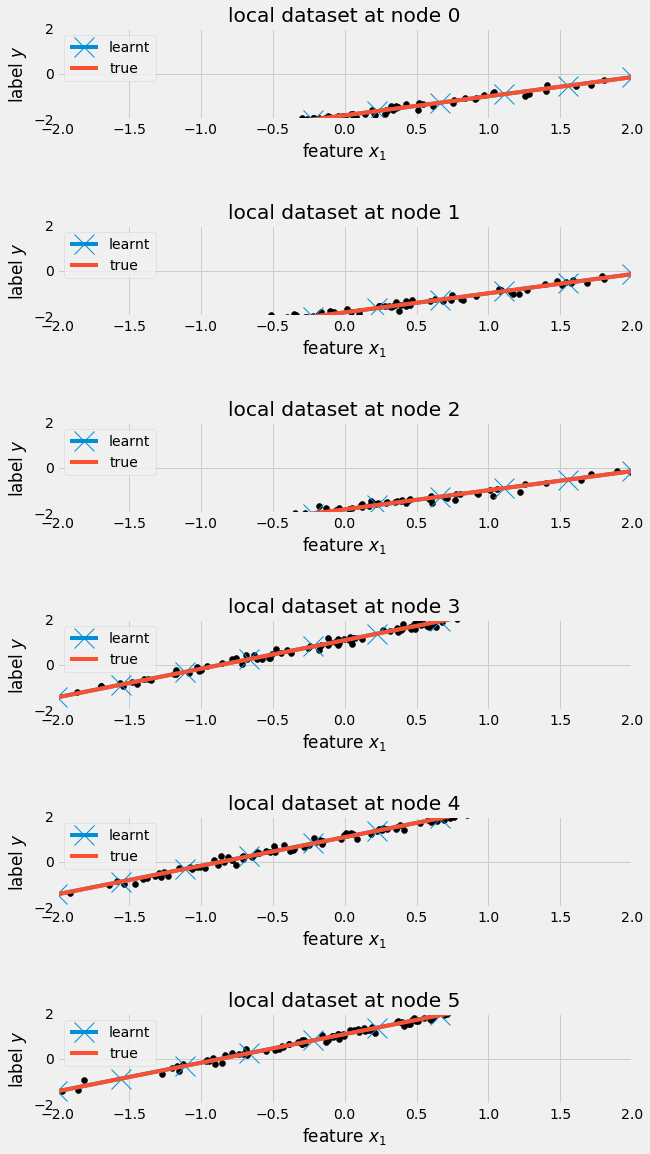

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(G.nodes),figsize=(10,17))
plt.style.use('fivethirtyeight')
    
# define a grid of nrgridpoints feature vectors that are used to evaluate ("probe") a linear 
# hypothesis map h(x) = w1*x1+w2*x2+...

nrgridpoints = 10
X_grid = np.hstack((np.linspace(-2.0, 2.0, nrgridpoints).reshape(-1,1),np.ones((nrgridpoints,1))))

for iter_node in G.nodes: 
    X = G.nodes[iter_node]["X"]
    y = G.nodes[iter_node]["y"]
    learnt_weights = G.nodes[iter_node]["w"]
    txt="local dataset at node "+str(iter_node)
    axs[iter_node].set_ylim([-2, 2])
    axs[iter_node].set_xlim([-2, 2])
    axs[iter_node].title.set_text(txt)
    axs[iter_node].scatter(X[:,0], y, color='black')
    
    # illustrate the learnt weights by a straight line obtained by evaluating the 
    # corresponding linear predictor for a regular grid of feature values X_grid
    axs[iter_node].plot(X_grid[:,0], X_grid.dot(learnt_weights),markersize=20,marker="x",label = "learnt")
    
    # illustrate the optimal predictor obtained from the ground truth weight vector
    axs[iter_node].plot(X_grid[:,0], X_grid.dot(true_weights[:,G.nodes[iter_node]["block"]]), label ="true")
    axs[iter_node].legend(loc='upper left')
    axs[iter_node].set_xlabel("feature $x_1$")
    axs[iter_node].set_ylabel("label $y$")
    

plt.tight_layout(pad=3.0)
plt.show()

# Demo 2.4 - Weather Data Network

The code snippet below generates an empirical graph `G_FMI` whose nodes represent weather observation stations of the Finnish Meteorological Institute (https://en.ilmatieteenlaitos.fi/). Each node of `G_FMI` will be assigned a local dataset that consists of daily weather recordings at the corresponding weather station. 

In [33]:
import random
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import datetime as dt
import geopy.distance
import networkx as nx
from fmiopendata.wfs import download_stored_query

# read in raw data which has been downloaded from FMI 

data = pd.read_csv('https://raw.githubusercontent.com/ieeespcasfinland/ieeespcasfinland.github.io/main/FMIData.csv')

# determine number of different weather stations for which observations are available 

num_stations = len(data.station.unique())

In [34]:
G_FMI = nx.Graph()
G_FMI.add_nodes_from(range(0,num_stations))

In [35]:
# add node attributes: station name,feature, and label
for i,station in enumerate(data.station.unique()):
    df = data[data.station==station]
    G_FMI.nodes[i]['name'] = station   # name of the i-th weather station
    G_FMI.nodes[i]['coord'] = (df.latitude.unique()[0],df.longitude.unique()[0]) # coordinates of i-th weather station 
    G_FMI.nodes[i]['X'] = df.min_temp.to_numpy().reshape(-1,1)   # feature matrix for local dataset at node i
    G_FMI.nodes[i]['y'] = df.max_temp.to_numpy()  # label vector for local dataset at node i

In [36]:
def get_dist(graph,nodeA,nodeB):
    """calculate the distance between two different stations"""
    coord_1 = graph.nodes[nodeA]['coord']
    coord_2 = graph.nodes[nodeB]['coord']
    return geopy.distance.geodesic(coord_1, coord_2).miles

def add_edges(graph,total_neigh=4):
    num_nodes = graph.number_of_nodes()
    for i in range(num_nodes):
            node_dists = []
            '''
            a list containing the distance between node i and other nodes of the graph
            '''
            for j in range(num_nodes):
                if j == i:
                    continue
                node_dists.append(get_dist(graph,i, j))

            # sort node_dists in order to pick the nearest nodes to the node i 
            node_dists.sort(reverse=False)
            node_cnt = 0
            for j in range(num_nodes):

                if node_cnt >= total_neigh:
                    break

                if j == i:
                    continue

                # calculate the distance between node i and j of the graph
                dist = get_dist(graph,i, j)
                if dist == 0 or dist >= node_dists[total_neigh]:
                    continue
                node_cnt += 1
                graph.add_edge(i, j)
    return graph

In [37]:
G_FMI = add_edges(G_FMI,total_neigh=4)

<function matplotlib.pyplot.show(*args, **kw)>

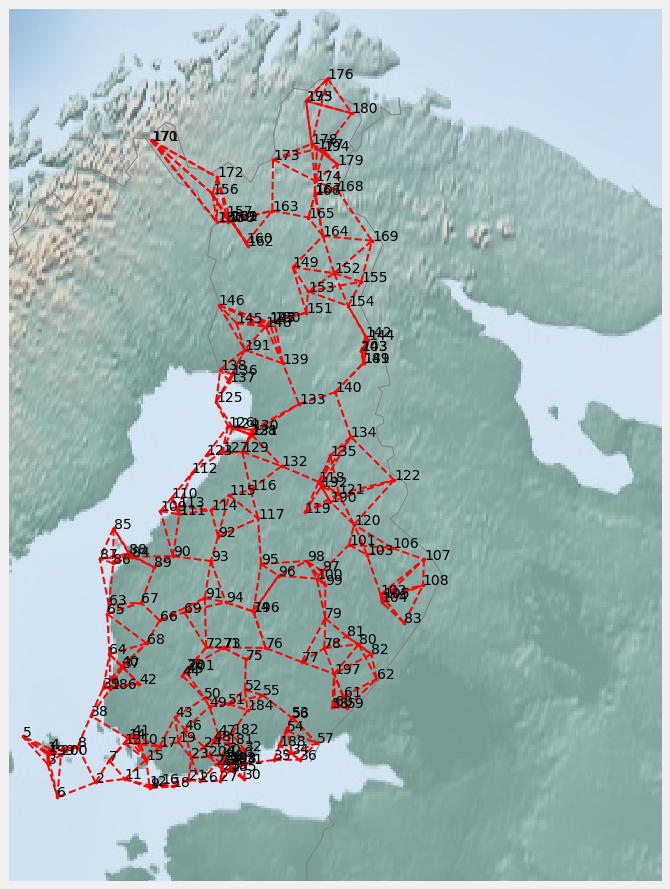

In [38]:
from mpl_toolkits.basemap import Basemap
import pygeos
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math

coords = [G_FMI.nodes[i]['coord'] for i in range(num_stations)]
df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])

coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
#print(coords)

#figure = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(20,15))

#fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='l', 
            lat_0=64.8238, lon_0=28.2179,
            width=1.05E6, height=1.4E6)
m.shadedrelief()
m.drawcountries(color='gray',linewidth=1)
m.drawstates(color='gray')
x, y = m(df_coords["longitude"].to_numpy(), df_coords["latitude"].to_numpy())  # transform coordinates
ax.scatter(x, y, 10, marker='o', color='Red')

for i, txt in enumerate(df_coords.index):
    ax.annotate(txt, (x[i], y[i]))

for edge_dmy in G_FMI.edges:
    ax.plot([x[edge_dmy[0]],x[edge_dmy[1]]],[y[edge_dmy[0]],y[edge_dmy[1]]],'r--',lw=2)
    
plt.show

# Task 2.1 

Study how changing the edge weights in the code snippet for Demo 2.1. affects the results obtained in Demo 2.2 and Demo 2.3. Currently there is no edge between block 0 (nodes 0,1,2) and block 1 (nodes 3,4,5). Add a single edge between node 2 and 3 and observe how the learnt weight vectors (stored in the node attribute `G.nodes[iter_node]["w"]`) varies. Also study the effect of using varying number of GD steps (using variable `N_GD`) and varying number of network averaging iterations (set in variable `N_AV`).

# Task 2.2

Modify Demo 2.3. by replacing the synthetic dataset with the networked weather dataset `G_FMI` generated in Demo 2.4.